# Analysis of CLIP similarities on one movie

In [1]:
import sys
sys.path.append("/home/simon/mount/astranaar/moment_detr")
import os
from IPython.utils import io
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.manifold import TSNE
from tqdm import tqdm

import torch

from moment_detr.config import BaseOptions
from moment_detr.transformer import build_transformer
from moment_detr.position_encoding import build_position_encoding
from moment_detr.clip_similarity import clip_filter_proposals
from moment_detr.setup_clip_training import setup_training, set_seed, data_to_device



In [2]:
with io.capture_output() as captured:
    opt = BaseOptions()
    opt.initialize()
    opt = opt.parse()
local_root = '/home/simon/data/'

opt.train_path = os.path.join(local_root, 'mad_dataset/annotations/MAD_train.json')
opt.eval_path_long_nlq = os.path.join(local_root, 'mad_dataset/annotations/MAD_test.json')
opt.eval_path = os.path.join(local_root, 'mad_dataset/annotations/MAD_val.json')
opt.t_feat_dir = os.path.join(local_root, 'mad_dataset/')
opt.v_feat_dirs = [os.path.join(local_root, 'mad_dataset/')]
#opt.resume = os.path.join(local_root, 'mad_dataset/momentDETR_results/CLIP_L14_bsz256_lr1e-4_dr1_wl30_fps5_lws4_lloss4_closs4_ret_tok_prop/model_best.ckpt')
opt.resume = None
opt.concat_sims = False

model, criterion, optimizer, lr_scheduler, opt, train_loader, val_loader = setup_training(mode='train', opt=opt, batch_size=1, num_workers=0,use_clip_prefiltering=False)
dataloader = iter(train_loader)

2023-01-20 17:26:41.602:INFO:moment_detr.inference - setup model/optimizer/scheduler
2023-01-20 17:26:42.801:INFO:moment_detr.inference - CUDA enabled.
2023-01-20 17:26:42.810:WARNING:moment_detr.inference - If you intend to evaluate the model, please specify --resume with ckpt path
2023-01-20 17:26:42.811:INFO:moment_detr.setup_clip_training - Model MomentDETR(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=1024, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=1024, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)


Parameter Count: all 4,403,977; trainable 4,403,977


2023-01-20 17:26:44.947:INFO:moment_detr.long_nlq_dataset - LOADING: /home/simon/data/mad_dataset/CLIP_L14_language_tokens_features.h5
2023-01-20 17:26:44.948:INFO:moment_detr.long_nlq_dataset - LOADING: /home/simon/data/mad_dataset/CLIP_L14_frames_features_5fps.h5
2023-01-20 17:26:44.948:INFO:moment_detr.long_nlq_dataset - LOADING: /home/simon/data/mad_dataset/annotations/MAD_val.json


In [3]:
batch = next(dataloader)
target, data, qid, windows = batch
clip_metrics = {}
_data, _target, windows, metrics, sims = clip_filter_proposals(data[0],target[0],7,300,clip_metrics,windows[0],-1)
movie = data[0]['src_vid']
topk_movie = _data['src_vid']
topk_target = _target

t = topk_target['is_foreground'].argmax().item()
rounded_frames_idx = [round(t*5) for t in target[0]['anno']['ext_timestamps']]

start_end_relative_to_window = [r-w for r,w in zip(rounded_frames_idx, windows[t])]
middle_frame = int(np.mean(rounded_frames_idx) -rounded_frames_idx[0])
start_end_frames = [_data['src_vid'][t][i] for i in start_end_relative_to_window]
middle_frame = _data['src_vid'][t][middle_frame]

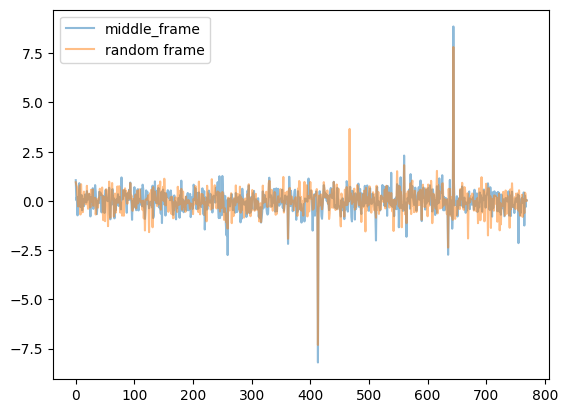

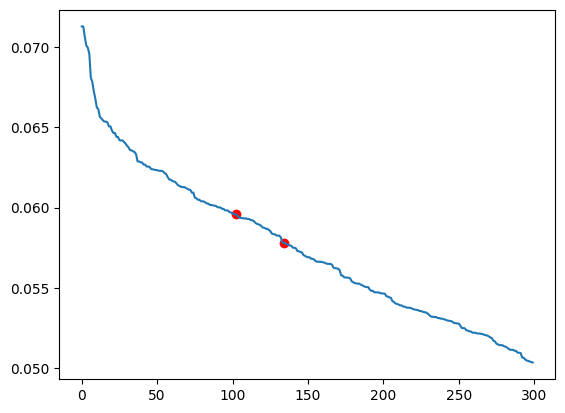

In [4]:
#labels = ['start frame','end frame', 'middle_frame', 'random frame']
labels = ['middle_frame', 'random frame']
for idx, frame in enumerate([middle_frame, _data['src_vid'][20][0]]):
    plt.plot(frame, label = labels[idx], alpha=0.5)
plt.legend(), plt.show()

plt.plot(sims)
for t in torch.where(topk_target['is_foreground']==1)[0]:
    plt.scatter(t, sims[t], c='red')
plt.show()

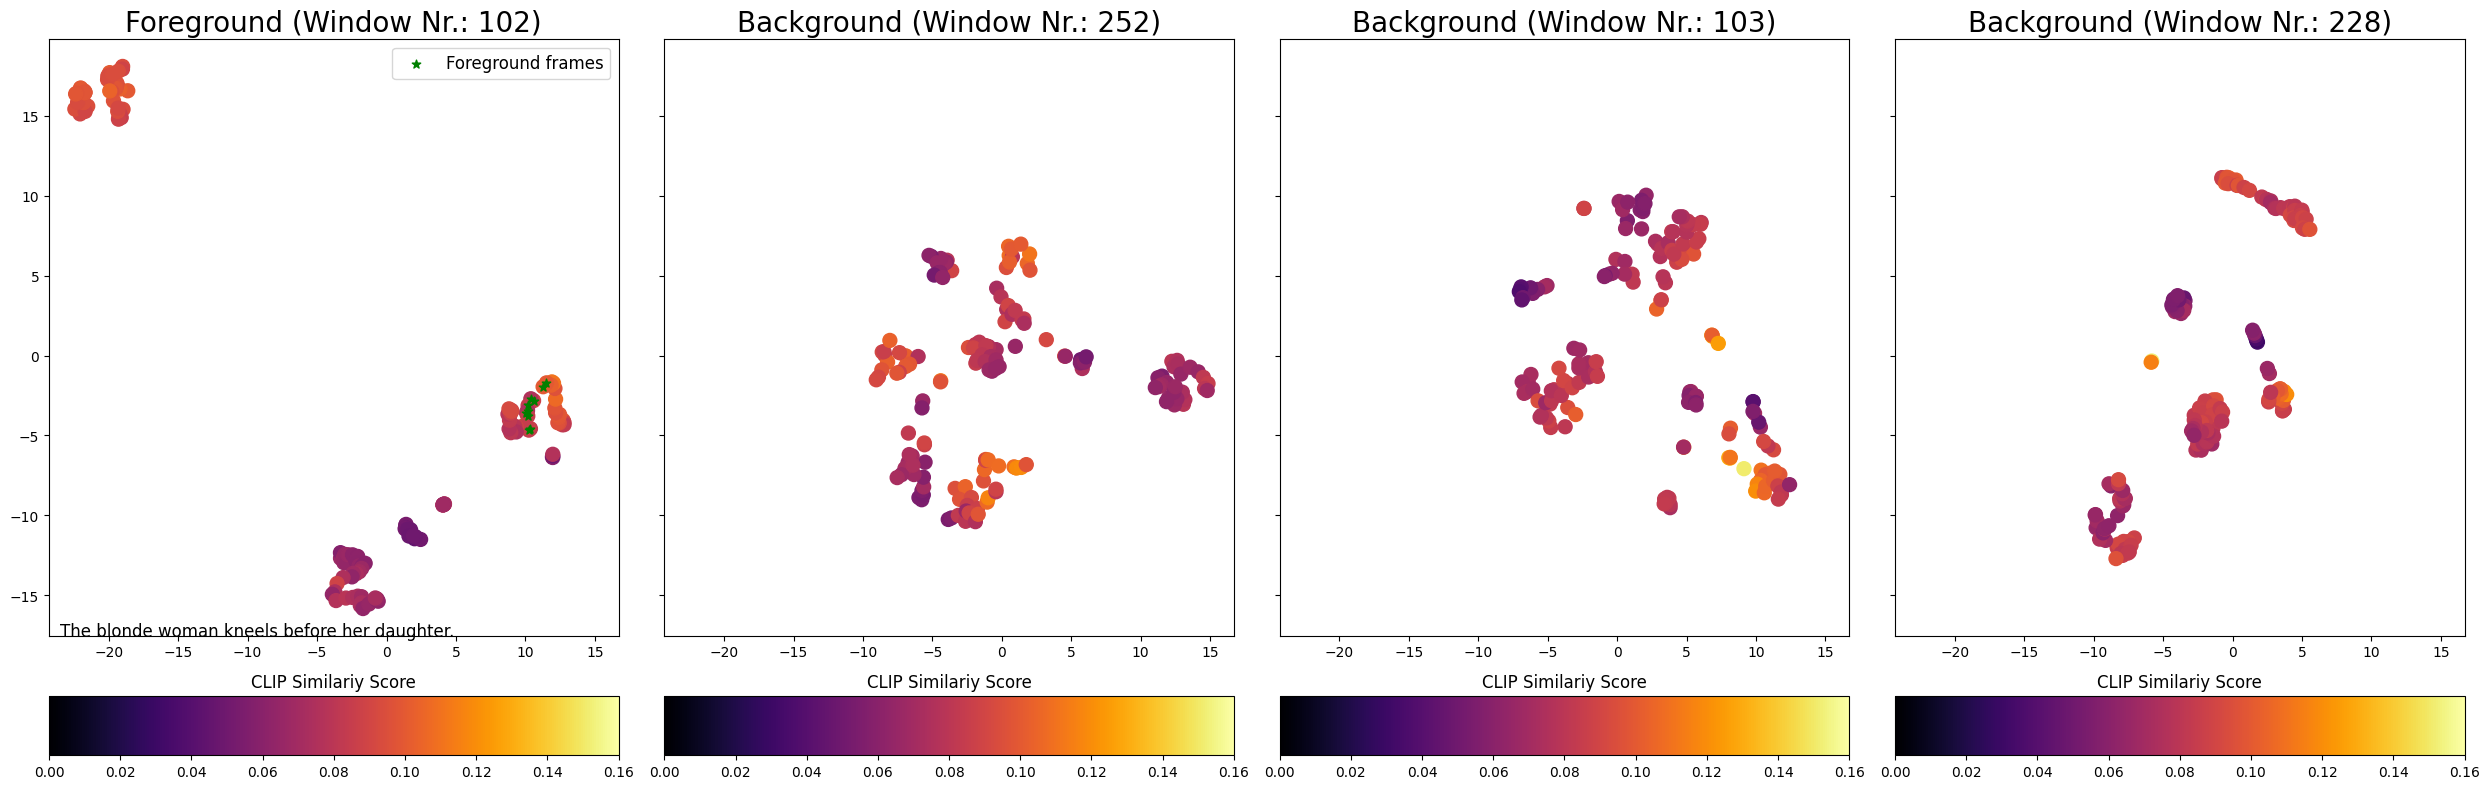

In [5]:
foreground_window_idx = topk_target['is_foreground'].argmax().item()
background_window_idx = [np.random.choice(torch.where(topk_target['is_foreground']==0)[0]) for _ in range(3)]

sentence = target[0]['anno']['sentence']
line_break = 10
words = sentence.split()
sentence = [words[i] + ('\n' if (i+1) % line_break == 0 else ' ') for i in range(len(words))]
sentence = ''.join(sentence)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(25, 8), sharey=True, sharex=True)

for idx, ax, title in zip([foreground_window_idx] + background_window_idx, (ax1, ax2, ax3, ax4), ['Foreground']+['Background']*3):

    text = data[0]['src_txt'][idx,-1].unsqueeze(0)
    frames = data[0]['src_vid'][idx][...,:-2]
    sims = text @ frames.T
    sims = sims / sims.norm(dim=-1, keepdim=True)
    # sims.shape = (1,150)

    # Perform t-SNE on the flattened data
    with io.capture_output():
        tsne = TSNE(n_components=2)
        data_tsne = tsne.fit_transform(topk_movie[idx])

    # Plot the t-SNE output
    foreground_dot = ax.scatter(data_tsne[:, 0], data_tsne[:, 1], c=sims, s=100, vmin=0, vmax=0.16, cmap='inferno')
    if title=='Foreground':
        data_fg = data_tsne[start_end_relative_to_window[0]:start_end_relative_to_window[1]]
        ax.scatter(data_fg[:, 0], data_fg[:, 1],marker='*',c='g', s=40, label = 'Foreground frames')
        ax.legend(fontsize=12)
        ax.text(0.02, 0, sentence, fontsize=12, transform=ax.transAxes)


    ax.set_title(f'{title} (Window Nr.: {idx})', fontsize=20)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('bottom', size='10%', pad=0.6)
    #cax.set_xlabel('data label')  # cax == cb.ax

    clb = plt.colorbar(foreground_dot, ax=ax, cax=cax, orientation='horizontal')
    clb.ax.set_title('CLIP Similariy Score',fontsize=12)

    
plt.tight_layout()


In [6]:
dataloader

In [7]:
sentences = ['SOMEONE looks at', 'someone looks at', 'He looks at', 'She looks at']

batches, clip_batches = [],[]
for batch in tqdm(train_loader):
    target, data, qid, windows = batch
    if any([s in target[0]['anno']['sentence'] for s in sentences]):
        print('Sentence:' + target[0]['anno']['sentence'])
        clip_metrics = {}
        batches.append(batch)
        clip_batches.append(clip_filter_proposals(data[0],target[0],7,300,clip_metrics,windows[0],-1))
    if len(batches)==10:
        break



  0%|          | 362/280183 [01:35<17:12:23,  4.52it/s]

In [ ]:
any([s in target[0]['anno']['sentence'] for s in sentences])

False